# Submission to the ArangoDB Hackathon
## By Patrick Wendo

The dataset used in this notebook is available on [Kaggle](https://www.kaggle.com/datasets/andreuvallhernndez/myanimelist)

In [1]:
!pip3 install kagglehub pandas numpy networkx matplotlib nx_arangodb scipy python-dotenv
!pip3 install --upgrade langchain langchain-community langchain-openai langgraph

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
from arango import ArangoClient
from dotenv import load_dotenv

import networkx as nx
import nx_arangodb as nxadb
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import ast
import re
import os
import openai

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool


db = ArangoClient(hosts="http://localhost:8529").db(username="root", password="Ptsd314159", verify=True)

print(db)

anime = pd.read_csv(
    "./datasets/myanimelist/anime.csv"
)

anime.tail()

[15:29:21 +0300] [INFO]: NetworkX-cuGraph is unavailable: No module named 'cupy'.


<StandardDatabase _system>


,anime_id,title,type,score,scored_by,status,episodes,start_date,end_date,source,...,producers,licensors,synopsis,background,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms
24980,54574,Seizoki,movie,NaN,10,finished_airing,1.0,1964-01-01,1964-01-01,original,...,[],[],"This is an animation using the ""Kaki-mation"" t...",NaN,https://cdn.myanimelist.net/images/anime/1202/...,https://myanimelist.net/anime/54574/Seizoki,NaN,NaN,精造機,[]
24981,56159,Kanshajou,music,NaN,2,finished_airing,1.0,1993-02-02,1993-02-02,original,...,['NHK'],[],Music video for the song Kanshajou by Reiko Sa...,NaN,https://cdn.myanimelist.net/images/anime/1074/...,https://myanimelist.net/anime/56159/Kanshajou,NaN,NaN,感謝状,['Minna no Uta']
24982,56107,Kaijuu Sekai Seifuku,ona,NaN,2,currently_airing,NaN,2020-04-02,NaN,web_manga,...,[],[],Follows four dragon-like monsters who came to ...,NaN,https://cdn.myanimelist.net/images/anime/1859/...,https://myanimelist.net/anime/56107/Kaijuu_Sek...,NaN,NaN,かいじゅうせかいせいふく,[]
24983,56168,Yotsukado no Melody,music,NaN,1,finished_airing,1.0,2014-12-01,2014-12-01,original,...,['NHK'],[],Music video for the song Yotsukado no Melody b...,NaN,https://cdn.myanimelist.net/images/anime/1559/...,https://myanimelist.net/anime/56168/Yotsukado_...,NaN,NaN,四つ角のメロディー,['Minna no Uta']
24984,56202,Ame to Kusari,music,NaN,0,finished_airing,1.0,2015-08-05,2015-08-05,original,...,[],[],Music video for the song Ame to Kusari by otetsu.,NaN,https://cdn.myanimelist.net/images/anime/1518/...,https://myanimelist.net/anime/56202/Ame_to_Kusari,NaN,NaN,飴と鎖,['Candy and Chains']


## DATA EXPLORATION

- We have 2 datasets, anime and manga. 
- These are both relational datasets with a single entry having multiple values. We need to figure out how to represent this data as a graph. 

#### Our Strategy.
- We could represent this as an attributed graph with node attributes and edge attributes. An **attributed graph** is one where aside from node labels, or edge labels, a node or an edge will also have additional metadata. For example, in a graph about people, we could have a node with the label "Anna" with attributes `{position: "CEO", start_date: "2019-08-19"}`. 

- The node label would be the name of the anime/manga. We could also have some columns be extracted to nodes of their own. For instance, an anime could fall into multiple genres. We could have each of those as a separate node. Similarly for columns like studios, themes, producers, licensors and demographics.

In [3]:
anime_columns_to_fix = ["genres", "themes", "demographics", "title_synonyms", "studios"]

def rewrite_anime(col):
    anime[col] = anime[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

for col in anime_columns_to_fix:
    rewrite_anime(col)

#### Data Fix
- We drop the entries with `NaN` values.

In [4]:
anime.dropna(inplace=True)

##### Data Fix #2
- Because the anime, manga, genres, themes, etc etc will use an ID of some kind, we update the anime ID to be prefixed with `a_<id>`
- Further, the ID should not have any disallowed characters, like whitespace, slashes, backslashes, dots at the beginning, colons, asterisks, question marks, exclamation marks, plus signs, percent signs, ampersands or equal signs, so we perform a search and replace for the new fields. 

In [5]:
def sanitize_text(text):
    """Replace spaces with underscores and remove invalid characters."""
    text = re.sub(r'\s+', '_', text)  # Replace spaces with underscores
    text = re.sub(r'[:;]', '', text)  # Remove colons and semicolons
    return text

def update_anime_id(anime_df):
    """Update anime_id by concatenating it with title, then sanitize."""
    anime_df["anime_id"] = anime_df["anime_id"].astype(str) + "_" + anime_df["title"]
    anime_df["anime_id"] = anime_df["anime_id"].apply(sanitize_text)
    
    print(anime_df["anime_id"])  # Debugging output
    return anime_df


anime = update_anime_id(anime)
anime.head(1)


2              38524_Shingeki_no_Kyojin_Season_3_Part_2
3                                       9253_SteinsGate
7             40028_Shingeki_no_Kyojin_The_Final_Season
10                                      1535_Death_Note
12                                 40748_Jujutsu_Kaisen
                              ...                      
9453     54738_Majutsushi_Orphen_Hagure_Tabi_Seiiki-hen
9683                          38162_Rinshi!!_Ekoda-chan
11603                      43771_Vazzrock_The_Animation
12757                                   37787_Space_Bug
13971                           32582_Duel_Masters_VSRF
Name: anime_id, Length: 578, dtype: object


,anime_id,title,type,score,scored_by,status,episodes,start_date,end_date,source,...,producers,licensors,synopsis,background,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms
2,38524_Shingeki_no_Kyojin_Season_3_Part_2,Shingeki no Kyojin Season 3 Part 2,tv,9.05,1491491,finished_airing,10.0,2019-04-29,2019-07-01,manga,...,"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],Seeking to restore humanity's diminishing hope...,Shingeki no Kyojin adapts content from volumes...,https://cdn.myanimelist.net/images/anime/1517/...,https://myanimelist.net/anime/38524/Shingeki_n...,https://www.youtube.com/watch?v=hKHepjfj5Tw,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,[]


#### Data fix #3

- Arango DB requires a field with the key `_key` to function as the key for a node. 
- Any value that will become a node should have this key. 


In [6]:
def add_key_column(dataframe, id_column):
    dataframe['_key'] = dataframe[id_column]
    return dataframe

anime = add_key_column(anime, "anime_id")

#### Data Fix #4 
- We want specific columns to become individual dataframes. For instance, `"genres"`, `"themes"`, `"demographics"` and `"studios"` should be their own dataframes because each value in those dataframe will be their own nodes.



In [7]:
## Identify Key groups in the following columns: "genres", "themes", "demographics", "studios". These could be shared between anime entries.

def fix_keys(df):
    df["_key"] = df["_key"].astype(str).replace("-", "_", regex=True)
    df["_key"] = df["_key"].astype(str).replace(" ", "_", regex=True)
    return df

def build_new_dataframe(dataframe, column):
    new_explode = anime.explode(column)
    new_dataframe = new_explode.groupby(column)
    new_dataframe = new_dataframe.groups.keys()
    new_dataframe = pd.DataFrame(new_dataframe, columns=[column]).reset_index()
    new_dataframe = add_key_column(new_dataframe, column)
    new_dataframe = fix_keys(new_dataframe)
    new_dataframe = new_dataframe[[column, "_key"]]
    return new_dataframe


genre_dataframe = build_new_dataframe(anime, "genres")
demographics_dataframe = build_new_dataframe(anime, "demographics")
studios_dataframe = build_new_dataframe(anime, "studios")
themes_dataframe = build_new_dataframe(anime, "themes")


#### Data Fix #5
- removing unused attributes from the anime dataset. 
- Some columns in the dataset will not be used in defining the attributes for the anime dataset. We filter these out. 

In [8]:
# anime node attributes
node_label = "anime_id"
node_attributes = {
    "_key": "_key",
    "id": "anime_id",
    "name": "title",
    "type": "type", 
    "score": "score", 
    "status": "status",
    "start_date": "real_start_date", 
    "studios": "studios",
    "themes": "themes",
    "demographics": "demographics",
    "genres": "genres",
    "end_date": "real_end_date", 
    "source": "source", 
    "episode_duration": "episode_duration", 
    "total_duration": "total_duration",
    "sfw": "sfw", 
    "start_year": "start_year", 
    "start_season": "start_season", 
    "broadcast_day": "broadcast_day",
    "main_picture": "main_picture",
    "url": "url",
    "trailer_url": "trailer_url",
    "title_english": "title_english",
    "title_japanese": "title_japanese",
    "title_synonyms": "title_synonyms" 
}

# (node_attributes.values())
anime = anime[anime.columns.intersection(list(node_attributes.values()))]
anime

,anime_id,title,type,score,status,source,episode_duration,total_duration,sfw,start_year,...,themes,demographics,studios,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms,_key
2,38524_Shingeki_no_Kyojin_Season_3_Part_2,Shingeki no Kyojin Season 3 Part 2,tv,9.05,finished_airing,manga,0 days 00:23:55,0 days 03:59:10,True,2019.0,...,"[Gore, Military, Survival]",[Shounen],[Wit Studio],https://cdn.myanimelist.net/images/anime/1517/...,https://myanimelist.net/anime/38524/Shingeki_n...,https://www.youtube.com/watch?v=hKHepjfj5Tw,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,[],38524_Shingeki_no_Kyojin_Season_3_Part_2
3,9253_SteinsGate,Steins;Gate,tv,9.07,finished_airing,visual_novel,0 days 00:24:20,0 days 09:44:00,True,2011.0,...,"[Psychological, Time Travel]",[],[White Fox],https://cdn.myanimelist.net/images/anime/1935/...,https://myanimelist.net/anime/9253/Steins_Gate,https://www.youtube.com/watch?v=27OZc-ku6is,Steins;Gate,STEINS;GATE,[],9253_SteinsGate
7,40028_Shingeki_no_Kyojin_The_Final_Season,Shingeki no Kyojin: The Final Season,tv,8.80,finished_airing,manga,0 days 00:23:55,0 days 06:22:40,True,2021.0,...,"[Gore, Military, Survival]",[Shounen],[MAPPA],https://cdn.myanimelist.net/images/anime/1000/...,https://myanimelist.net/anime/40028/Shingeki_n...,https://www.youtube.com/watch?v=SlNpRThS9t8,Attack on Titan: Final Season,進撃の巨人 The Final Season,"[Shingeki no Kyojin Season 4, Attack on Titan ...",40028_Shingeki_no_Kyojin_The_Final_Season
10,1535_Death_Note,Death Note,tv,8.62,finished_airing,manga,0 days 00:23:00,0 days 14:11:00,True,2006.0,...,"[Detective, Psychological]",[Shounen],[Madhouse],https://cdn.myanimelist.net/images/anime/9/945...,https://myanimelist.net/anime/1535/Death_Note,https://www.youtube.com/watch?v=Vt_3c8BgxV4,Death Note,デスノート,[DN],1535_Death_Note
12,40748_Jujutsu_Kaisen,Jujutsu Kaisen,tv,8.63,finished_airing,manga,0 days 00:23:55,0 days 09:34:00,True,2020.0,...,[School],[Shounen],[MAPPA],https://cdn.myanimelist.net/images/anime/1171/...,https://myanimelist.net/anime/40748/Jujutsu_Ka...,https://www.youtube.com/watch?v=4A_X-Dvl0ws,Jujutsu Kaisen,呪術廻戦,"[Sorcery Fight, JJK]",40748_Jujutsu_Kaisen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9453,54738_Majutsushi_Orphen_Hagure_Tabi_Seiiki-hen,Majutsushi Orphen Hagure Tabi: Seiiki-hen,tv,6.04,finished_airing,light_novel,0 days 00:23:00,0 days 04:36:00,True,2023.0,...,[Martial Arts],[],[Studio Deen],https://cdn.myanimelist.net/images/anime/1873/...,https://myanimelist.net/anime/54738/Majutsushi...,https://www.youtube.com/watch?v=4gX1ZdCL6qw,Sorcerous Stabber Orphen -Doom of Dragon's San...,魔術士オーフェンはぐれ旅 聖域編,"[Majutsushi Orphen Hagure Tabi 4th Season, Sor...",54738_Majutsushi_Orphen_Hagure_Tabi_Seiiki-hen
9683,38162_Rinshi!!_Ekoda-chan,Rinshi!! Ekoda-chan,tv,5.54,finished_airing,4_koma_manga,0 days 00:05:00,0 days 00:55:00,True,2019.0,...,[],[Seinen],"[Kinema Citrus, Ascension, Creators in Pack, Z...",https://cdn.myanimelist.net/images/anime/1165/...,https://myanimelist.net/anime/38162/Rinshi_Eko...,https://www.youtube.com/watch?v=KdB7LnGEtxo,Rinshi!! Ekodachan,臨死!!江古田ちゃん,[Near Death!! Ekoda-chan],38162_Rinshi!!_Ekoda-chan
11603,43771_Vazzrock_The_Animation,Vazzrock The Animation,tv,5.44,finished_airing,music,0 days 00:23:40,0 days 05:07:40,True,2022.0,...,"[Idols (Male), Music]",[],[PRA],https://cdn.myanimelist.net/images/anime/1488/...,https://myanimelist.net/anime/43771/Vazzrock_T...,https://www.youtube.com/watch?v=OcN0l1qDsHk,Vazzrock the Animation,VAZZROCK THE ANIMATION,[],43771_Vazzrock_The_Animation
12757,37787_Space_Bug,Space Bug,tv,6.02,finished_airing,original,0 days 00:23:45,0 days 10:17:30,True,2018.0,...,[Space],[],"[Studio W.Baba, P.I.C.S.]",https://cdn.myanimelist.net/images/anime/1063/...,https://myanimelist.net/anime/37787/Space_Bug,https://www.youtube.com/watch?v=ROUtYnPQBDI,The Journey Home,スペースバグ,[],37787_Space_Bug


#### Data fix #6
- Because ArangoDB and NetworkX needs a set of edges, we define an edgelist dataframe that contains only the source key and destination key. 


In [9]:
## Building the edge list. 

def build_edge_list(dataframe1, dataframe2, merge_field_1, merge_field_2):
    exploded_df = dataframe1.explode(merge_field_1)
    edge_list_df = exploded_df.merge(dataframe2, left_on=merge_field_1, right_on=merge_field_2)
    edge_list_df = edge_list_df[["_key_x", "_key_y"]]
    return edge_list_df

demographics_edge_list = build_edge_list(anime, demographics_dataframe, "demographics", "_key")
genres_edge_list = build_edge_list(anime, genre_dataframe, "genres", "_key")
themes_edge_list = build_edge_list(anime, themes_dataframe, "themes", "_key")
studios_edge_list = build_edge_list(anime, studios_dataframe, "studios", "_key")


### NetworkX

- Let's attempt to add the nodes from the dataframes and the edges from the edgelist

In [10]:
genres_edge_list

,_key_x,_key_y
0,38524_Shingeki_no_Kyojin_Season_3_Part_2,Action
1,38524_Shingeki_no_Kyojin_Season_3_Part_2,Drama
2,9253_SteinsGate,Drama
3,9253_SteinsGate,Suspense
4,40028_Shingeki_no_Kyojin_The_Final_Season,Action
...,...,...
1307,37787_Space_Bug,Adventure
1308,32582_Duel_Masters_VSRF,Action
1309,32582_Duel_Masters_VSRF,Adventure
1310,32582_Duel_Masters_VSRF,Comedy


In [11]:
# Adding nodes for "genres", "themes", "demographics", "studios"
G = nx.Graph()

def add_nodes(G, node_df, key):
    for index, row in node_df.iterrows():
        node_id = row[key]  # Get node identifier (_key)
        attributes = row.drop(key).to_dict()  # Convert other columns to a dictionary
        G.add_node(node_id, **attributes)

add_nodes(G, anime, "_key")
add_nodes(G, genre_dataframe, "genres")
add_nodes(G, themes_dataframe, "themes")
add_nodes(G, demographics_dataframe, "demographics")
add_nodes(G, studios_dataframe, "studios")

# # Add edgelists
G.add_edges_from(genres_edge_list[["_key_x", "_key_y"]].itertuples(index=False, name=None))
G.add_edges_from(demographics_edge_list[["_key_x", "_key_y"]].itertuples(index=False, name=None))
G.add_edges_from(studios_edge_list[["_key_x", "_key_y"]].itertuples(index=False, name=None))
G.add_edges_from(themes_edge_list[["_key_x", "_key_y"]].itertuples(index=False, name=None))


# G = nx.from_pandas_edgelist(genres_edge_list, "_key_y", "_key_x")
G.nodes(data=True)

NodeDataView({'38524_Shingeki_no_Kyojin_Season_3_Part_2': {'anime_id': '38524_Shingeki_no_Kyojin_Season_3_Part_2', 'title': 'Shingeki no Kyojin Season 3 Part 2', 'type': 'tv', 'score': 9.05, 'status': 'finished_airing', 'source': 'manga', 'episode_duration': '0 days 00:23:55', 'total_duration': '0 days 03:59:10', 'sfw': True, 'start_year': 2019.0, 'start_season': 'spring', 'real_start_date': '2019-04-29', 'real_end_date': '2019-07-01', 'broadcast_day': 'monday', 'genres': ['Action', 'Drama'], 'themes': ['Gore', 'Military', 'Survival'], 'demographics': ['Shounen'], 'studios': ['Wit Studio'], 'main_picture': 'https://cdn.myanimelist.net/images/anime/1517/100633l.jpg', 'url': 'https://myanimelist.net/anime/38524/Shingeki_no_Kyojin_Season_3_Part_2', 'trailer_url': 'https://www.youtube.com/watch?v=hKHepjfj5Tw', 'title_english': 'Attack on Titan Season 3 Part 2', 'title_japanese': '進撃の巨人 Season3 Part.2', 'title_synonyms': []}, '9253_SteinsGate': {'anime_id': '9253_SteinsGate', 'title': 'Stei

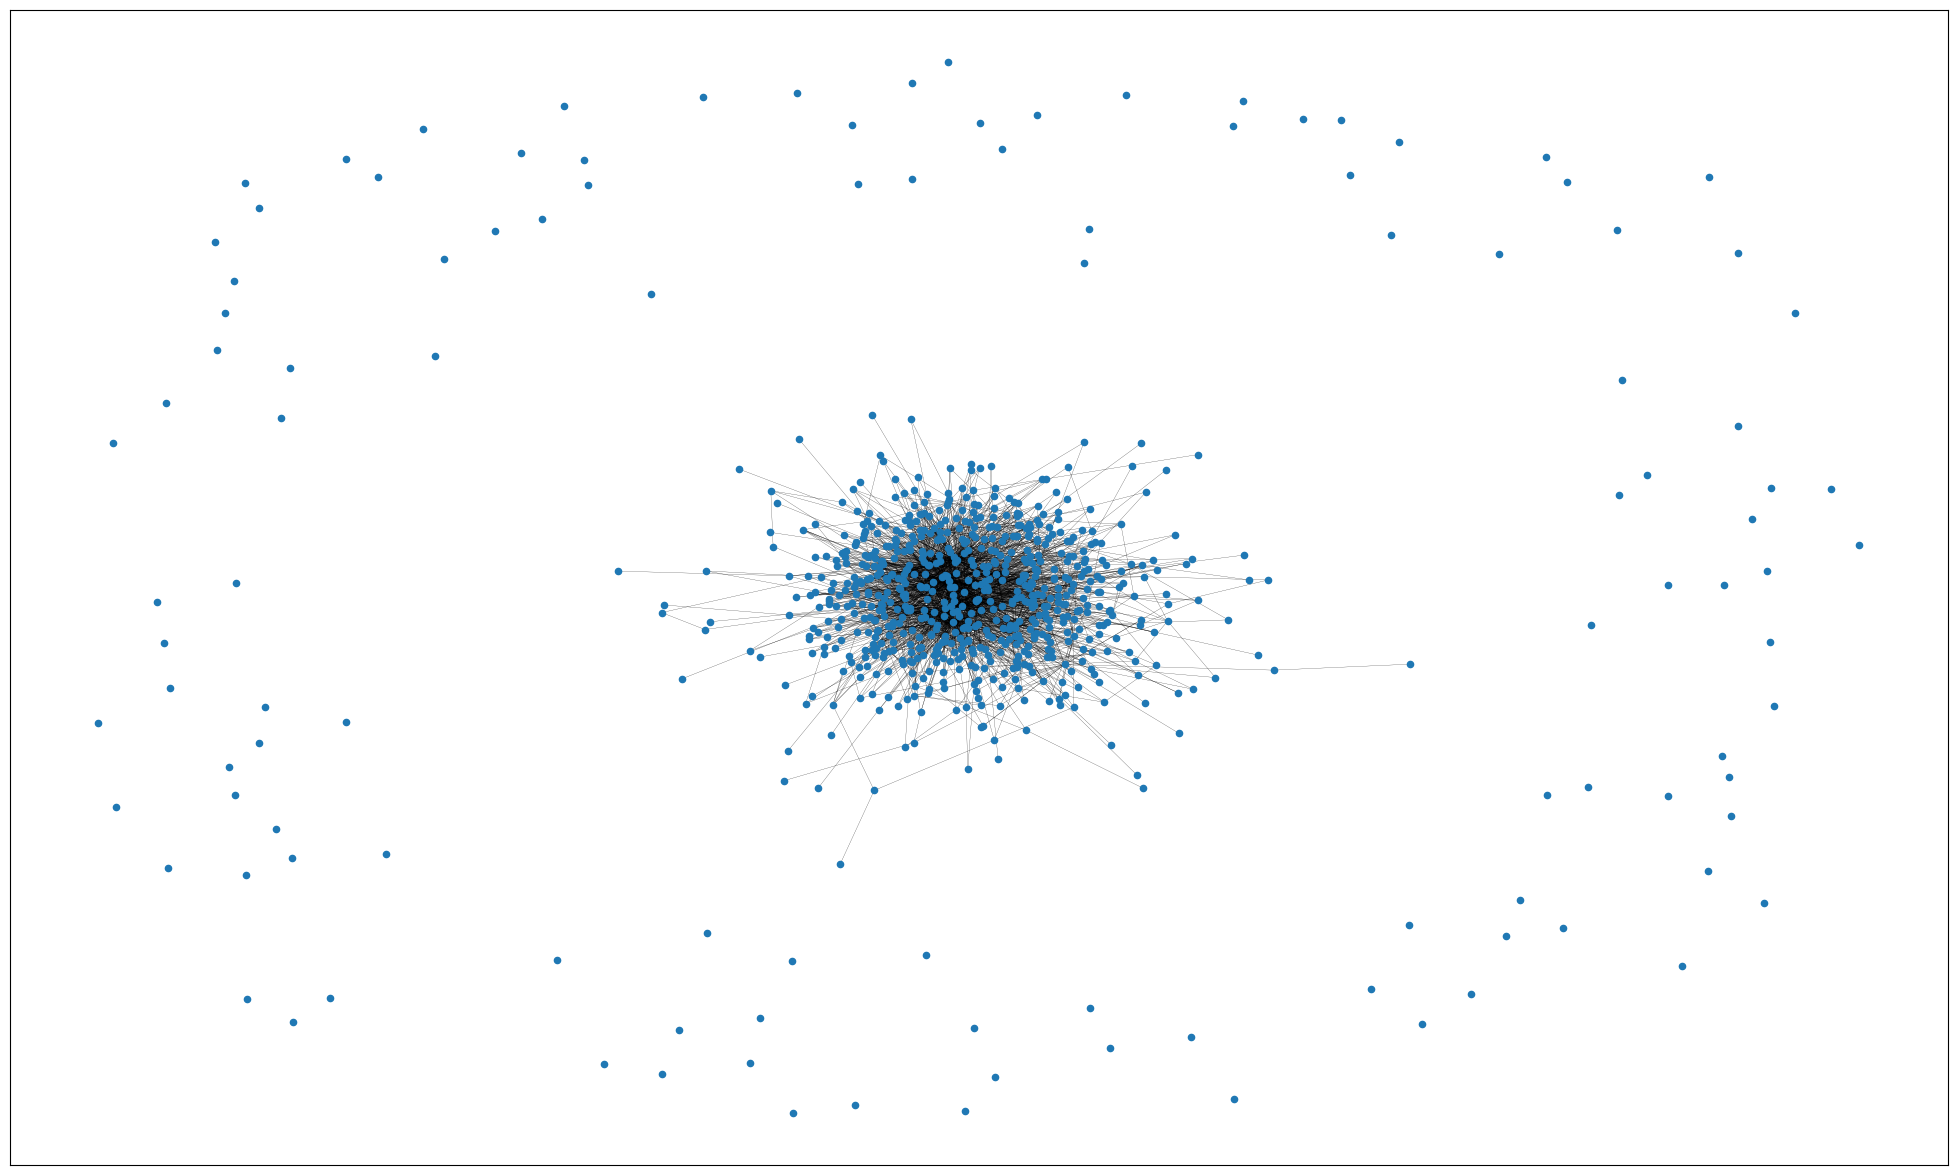

In [12]:
plot_options = {"node_size": 20, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(G, iterations=15, seed=1219)
fig, ax = plt.subplots(figsize=(25, 15))
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

### Load into Arango DB
- Now that we have the graph in networkX, we will load it into ArangoDB

In [13]:
G.nodes

NodeView(('38524_Shingeki_no_Kyojin_Season_3_Part_2', '9253_SteinsGate', '40028_Shingeki_no_Kyojin_The_Final_Season', '1535_Death_Note', '40748_Jujutsu_Kaisen', '35760_Shingeki_no_Kyojin_Season_3', '23273_Shigatsu_wa_Kimi_no_Uso', '16498_Shingeki_no_Kyojin', '1_Cowboy_Bebop', '47778_Kimetsu_no_Yaiba_Yuukaku-hen', '30276_One_Punch_Man', '25777_Shingeki_no_Kyojin_Season_2', '38000_Kimetsu_no_Yaiba', '28891_Haikyuu!!_Second_Season', '2001_Tengen_Toppa_Gurren_Lagann', '48583_Shingeki_no_Kyojin_The_Final_Season_Part_2', '34599_Made_in_Abyss', '20583_Haikyuu!!', '44511_Chainsaw_Man', '37991_JoJo_no_Kimyou_na_Bouken_Part_5_Ougon_no_Kaze', '31933_JoJo_no_Kimyou_na_Bouken_Part_4_Diamond_wa_Kudakenai', '45576_Mushoku_Tensei_Isekai_Ittara_Honki_Dasu_Part_2', '26055_JoJo_no_Kimyou_na_Bouken_Part_3_Stardust_Crusaders_2nd_Season', '22535_Kiseijuu_Sei_no_Kakuritsu', '31043_Boku_dake_ga_Inai_Machi', '39535_Mushoku_Tensei_Isekai_Ittara_Honki_Dasu', '9756_Mahou_Shoujo_Madoka★Magica', '9989_Ano_Hi_Mita_H

In [14]:
graph_name = "Anime_Subset"
nodes_collection = "anime_nodes"
edges_collection = "anime_edges"

if not db.has_graph(graph_name):
    graph = db.create_graph(graph_name)
    if not graph.has_vertex_collection(nodes_collection):
        graph.create_vertex_collection(nodes_collection)
    if not graph.has_edge_collection(edges_collection):
        graph.create_edge_definition(
            edge_collection=edges_collection,
            from_vertex_collections=[nodes_collection],
            to_vertex_collections=[nodes_collection]
        )
    else: 
        graph = db.graph(graph_name)

def sanitize_key(key):
    """Ensure _key is a valid string for ArangoDB (no spaces, special characters except '_', '-')."""
    key = str(key)  # Ensure key is a string
    key = re.sub(r'\s+', '_', key)  # Replace spaces with underscores
    key = re.sub(r'[^a-zA-Z0-9_-]', '-', key)  # Replace invalid characters with hyphens
    return key

def clean_data(data):
    """Sanitize node attributes, ensuring numeric fields are correct and None is handled."""
    clean_data = {}
    for k, v in data.items():
        if isinstance(v, (int, float, bool)):  # Keep numbers as is
            clean_data[k] = v
        elif v is None:  # Replace None with empty string or remove
            clean_data[k] = ""
        else:
            clean_data[k] = str(v)  # Convert everything else to string
    return clean_data

def load_nodes(G, nodes_collection, db):
    nodes = []
    failed_nodes = []  # Store problematic nodes

    for node, data in G.nodes(data=True):
        clean_key = sanitize_key(node)  # Ensure _key is safe
        clean_node_data = clean_data(data)  # Sanitize node attributes

        nodes.append({
            "_key": clean_key,
            **clean_node_data
        })

    if nodes:
        try:
            db.collection(nodes_collection).insert_many(nodes, overwrite=True)
            print(f"✅ Loaded {len(nodes)} nodes into {nodes_collection}")
        except Exception as e:
            print(f"❌ Error inserting nodes: {e}")

            # Identify invalid data causing the error
            for node in nodes:
                try:
                    db.collection(nodes_collection).insert(node, overwrite=True)
                except Exception:
                    failed_nodes.append(node)  # Store the failing node

            print("❌ Failed nodes:", failed_nodes)  # Print bad nodes for debugging

    return nodes, failed_nodes  # Return successful & failed nodes


def load_edges(G, edges_collection, nodes_collection):
    edges=[]
    for u,v, data in G.edges(data=True):
        edges.append({
            "_from": f"{nodes_collection}/{u}",
            "_to": f"{nodes_collection}/{v}",
            **data
        })
    if edges:
        db.collection(edges_collection).insert_many(edges, overwrite=True)
        print(f"✅ Loaded {len(edges)} edges into {edges_collection}")

[node, failed_nodes]= load_nodes(G, nodes_collection, db)
load_edges(G, edges_collection, nodes_collection)
for node in failed_nodes:
    print(node["_key"])

✅ Loaded 804 nodes into anime_nodes
✅ Loaded 2511 edges into anime_edges


In [15]:
# G_adb = nxadb.Graph(
#     name="nxadb_anime",
#     db=db,
#     incoming_graph_data=G,
#     write_batch_size=50000, # feel free to modify
# )



In [16]:
# print(G_adb.degree(578))

## Building the Agentic App with LangChain & LangGraph

In [17]:
anime_graph = ArangoGraph(db)

In [36]:
load_dotenv(".env", verbose=True)


# Get the value
sambanova_key = os.getenv("SAMBANOVA_KEY")

client = openai.OpenAI(
    api_key=sambanova_key,
    base_url="https://api.sambanova.ai/v1",
)

response = client.chat.completions.create(
    model="Meta-Llama-3.1-405B-Instruct",
    messages=[{"role":"system","content":"You are a helpful assistant"},{"role":"user","content":"Hello"}],
    temperature=0.1,
    top_p=0.1
)

print(response.choices[0].message.content)

Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?


In [37]:
@tool
def text_to_aql_to_text(query: str):
    """This tool is available to invoke the
    ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute
    the query, and translate the result back into Natural Language.
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    chain = ArangoGraphQAChain.from_llm(
    	llm=llm,
    	graph=arango_graph,
    	verbose=True,
        allow_dangerous_requests=True
    )
    
    result = chain.invoke(query)

    return str(result["result"])